In [ ]:
#@title Googleドライブにマウントする
from google.colab import drive
drive.mount('/content/drive')

Googleドライブのマイドライブ内に解析専用のフォルダを作成する。

ここではEMGとする。そして下のworking_directoryを合わせる。

In [ ]:
mydrive = "/content/drive/MyDrive/"
#@title フォルダの設定
working_directory = "EMG" #@param {type:"string"}

In [26]:
#@title EMGを計測後センサから取り出したデータファイルの入ったフォルダ
folder_name = "mem-20211115-131617" #@param {type:"string"}
folderwithfile = mydrive+working_directory+"/"+folder_name+"/"

In [15]:
#@title 解析を始めるポイントの決定(5秒以降がよい)
start = 5100 #@param {type:"slider", min:0, max:10000, step:100}

In [18]:
#@title ココはこのまま実行
import os
import csv
import pandas as pd
import datetime
import glob
import numpy as np

os.chdir(mydrive+working_directory)
import emg
print(f"現在の作業ディレクトリ:{os.getcwd()}")

現在の作業ディレクトリ:/content/drive/MyDrive/EMG


In [25]:
#@title データの読み込みと処理後のデータの保存 { display-mode: "form" }
filename = glob.glob(folderwithfile+"mem-*.csv")
dat = pd.read_csv(filename[0],header=None)

bandpasslow = 15 
bandpasshigh = 350 

# EMG1
myd0 = dat.iloc[start:,2].to_numpy()
myd0_band = emg.bpf(myd0,1000,bandpasslow,bandpasshigh)
myd0_abs = np.abs(myd0_band)
val = emg.integral(myd0_abs,0,start,len(myd0_abs)-2)
for name,dd in zip(["rowdata","band","abs","integ"],[myd0,myd0_band,myd0_abs,val]):
    with open(f'{name}.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(dd.tolist())

In [5]:
## 各自の環境に合わせること。このままでは実行しない。
## ファイル名　現在書かれているのは例である。
filename = "/content/drive/Shareddrives/EMG2021/mem-20211115-131617/mem-1724-20211115-131500377.csv"
## ホームディレクトリ
direct = "/content/drive/Shareddrives/EMG2021/"

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import csv
import datetime,os

In [3]:
## ローパスフィルタ
def lpf(wave, fs, fe1):
    '''
    Parameter
    ----------
    wave:array-like  1Dのデータ
    fs:サンプリング周波数
    fe1:カットオフ周波数

    '''
    nyq = fs / 2.0
    b, a = signal.butter(4, fe1/nyq, btype='low')
    wave = signal.filtfilt(b, a, wave)
    return wave

# バンドパスフィルタ
def bpf(wave, fs, fe1, fe2):
    '''
    Parameter
    ----------
    fe1、fe2を通す
    wave:array-like  1Dのデータ
    fs:サンプリング周波数
    fe1,fe2:カットオフ周波数

    '''
    nyq = fs / 2.0
    b, a = signal.butter(4, [fe1/nyq, fe2/nyq], btype='band')
    wave = signal.filtfilt(b, a, wave)
    return wave


## 積分値
def integral(x, s0, startindex, endindex, tau=0.001):
    '''
    Return 被積分データ配列xの台形則にもとずく積分データ配列.
    
    Parameters
    ----------
    x : array-like
        被積分データ. 1-D numpy配列推奨.
    s0 : int or float
        初期値(積分定数).
    statindex : int
        被積分データ配列xの最初のindex.
    endindex : int
        被積分データ配列xの最後のindex.
    tau : float, optional (0.001)
        積分区切り幅.
    '''
    s = s0
    s_arr = [s0]
    for i in range(startindex, endindex+1):
        s += (x[i] + x[i+1]) / 2 * tau
        s_arr.append(s)
    return np.array(s_arr)

In [ ]:
# ディレクトリの作成
dt_now = datetime.datetime.now()
savetime = dt_now.strftime('%Y_%m_%d-%H:%M:%S')

os.makedirs(f"{direct}{savetime}")
direct = f"{direct}{savetime}"

In [ ]:
dat = pd.read_csv(filename,header=None)

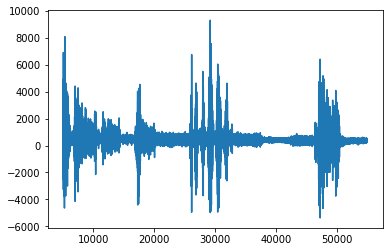

In [ ]:
plt.plot(dat.iloc[5000:,2])

In [ ]:
# EMG1
myd0 = dat.iloc[5000:,2].to_numpy()
myd0_band = bpf(myd0,1000,15,350)
myd0_abs = np.abs(myd0_band)
myd0_envelope = lpf(myd0_abs,1000,40)

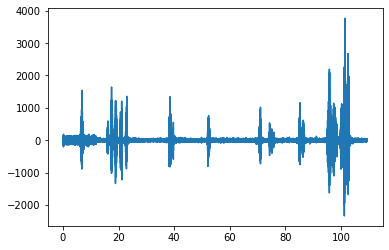

In [ ]:
fig = plt.figure()
t = np.linspace(0,len(myd0_band)/1000,len(myd0_band))
plt.plot(t,myd0_band)

In [ ]:
n0,n1 = 12000,14000

12000~14000[ms]の筋積分値:1150083.7152694943
筋積分値の差(14000-12000):945.1796269417692


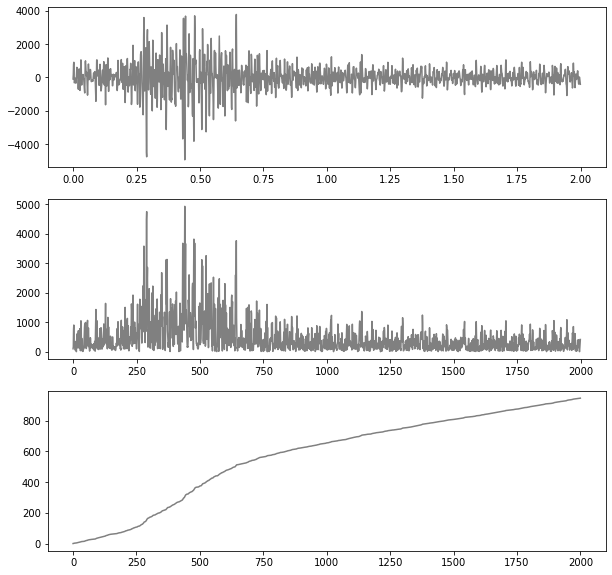

In [ ]:
fig = plt.figure(figsize=(10,10))
t = np.linspace(0,(n1-n0-1)/1000,(n1-n0-1))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(t,myd0_band[n0:n1-1],c="gray")
ax2.plot(myd0_abs[n0:n1-1],c="gray")
ax3.plot(integral(myd0_abs,0,n0,n1-1),c="gray")

plt.savefig(f"{direct}/fig_{n0}_{n1}.png")
integ = np.sum(integral(myd0_abs,0,n0,n1-1))
dif = integral(myd0_abs,0,n0,n1-1)[-1]-integral(myd0_abs,0,n0,n1-1)[0]
print(f"{n0}~{n1}[ms]の筋積分値:{integ}")
print(f"筋積分値の差({n1}-{n0}):{dif}")
with open(f"{direct}/data.txt", "w") as d:
    d.write('\n'.join([f"{n0}~{n1}[ms]の筋積分値:{integ}",f"筋積分値の差({n1}-{n0}):{dif}"]))

val = integral(myd0_abs,0,n0,n1-1)
pd.DataFrame(val).to_csv(f"{direct}/val.csv")

In [ ]:
val = integral(myd0_abs,0,n0,n1-1)

In [ ]:
pd.DataFrame(val).to_csv(f"{direct}/val.csv")

numpy.ndarray